In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

# 3. Download Data

### 3.1 Download with figshare API

In [2]:
# Use API to download data
article_id = "14096681"
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "NSWrainfall/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  
files = data["files"]     

## 3.2 Extract Zip File

In [6]:
%%time
# create zip file
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 4.24 s, sys: 5.4 s, total: 9.64 s
Wall time: 2min 6s


In [7]:
%%time
# extract data into directory
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 17.2 s, sys: 5.86 s, total: 23 s
Wall time: 32 s


# 4. Combine CSV

In [2]:
%%time

if os.path.exists("NSWrainfall/combined_data.csv"):
  df = pd.read_csv("NSWrainfall/combined_data.csv")
  
else:
  excluded_files = ["NSWrainfall\\observed_daily_rainfall_SYD.csv"]
  files = glob.glob('NSWrainfall/*.csv')
  files = list(set(files) - set(excluded_files))
  df = pd.concat((pd.read_csv(file, index_col=0)
                  .assign(model=re.findall("/([^_]*)", file)[0])  
                  for file in files)
                )
  df.to_csv("NSWrainfall/combined_data.csv")

CPU times: user 55.7 s, sys: 5.71 s, total: 1min 1s
Wall time: 1min 1s


| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken |
| --- | --- | --- | --- | --- | --- |
| Austin Shih | MacOS | 64GB | Intel i9 2.4 GHz 8-Core | Yes | 6m 20s |
| Renee Kwon | MacOS | 8GB | Dual-Core Intel Core i5 | Yes | 12min 27s |
| Wilfred Hass | Ubuntu 22.04 | 16GB | Intel i7-7700HQ 2.8 GHz 4-core | Yes | 6m 44s |
| Fujie Sun | WinOS | 16GB | AMD Ryzen 7 5800HS  | Yes | 8min 34s  |

In [3]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.9,-35.1,141.475,142.275,6.454416e-19,FGOALS-f3-L
1,1889-01-02 12:00:00,-35.9,-35.1,141.475,142.275,1.459099e-08,FGOALS-f3-L
2,1889-01-03 12:00:00,-35.9,-35.1,141.475,142.275,7.752986e-04,FGOALS-f3-L
3,1889-01-04 12:00:00,-35.9,-35.1,141.475,142.275,3.762391e-01,FGOALS-f3-L
4,1889-01-05 12:00:00,-35.9,-35.1,141.475,142.275,9.123590e-13,FGOALS-f3-L


**Comparisons:**

The time taken to combine the multiple csv files into one file varied for the members of our group depending on the specifications of our machines. Austin's MacOS machine with 64GB and an Intel i9 processor took the shortest time to merge the files. Wilfred's Ubuntu machine with 16GB RAM and an Intel i7 processor was just 24 seconds behind Austin, indicating that having a much higher RAM is not a significant component on the performance of merging a dataset of this size. As well, Fujie's Windows machine with the same 16GB took almost two minutes longer than Wilfred, further indicating that the processor of the machine or the operating system (or other factors not measured here) has a larger impact on the processing time of this task. Furthermore, Renee's MacOS computer with the older Intel i5 processor took the longest time, almost double the time of Austin's on the same OS but with an i9 processor. All members have SSD so we were not able to compare the results of SSD vs. HDD. 

# 5. Simple EDA

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken to Naively Load CSV | Changing dtype | Loading only Certain Columns |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Austin Shih | MacOS | 64GB | Intel i9 2.4 GHz 8-Core | Yes | 1m 17s | 1m 9s | 47s |
| Renee Kwon | MacOS | 8GB | Dual-Core Intel Core i5  | Yes | 3min 52s | 2min 34s | 1min 32s |
| Wilfred Hass | Ubuntu 22.04 | 16GB | Intel i7-7700HQ 2.8 GHz 4-core | Yes | 1m 30s | 1m 27s | 50.6s |
| Fujie Sun | WinOS | 16GB | AMD Ryzen 7 5800HS  | Yes | 2m 40s | 2m 29s | 1m 17s |

**Note** There will be memory issues if you run any two of the sections in one session. Please restart your kernel each time.

Let's say we are interested in the mean `lat_min` and median `lon_min`, along with the distribution of rain over the entire dataset. To perform this EDA, we use the `describe()` function and use pandas' built-in histogram plotting.

We find that loading the combined data with `dtype` that consume less memory only marginally speeds up the EDA (by about 21%). This also reduces our memory consumptions by a third with this dataset when going from `float64` to `float32`, trading precision for memory (3.50 GB to 2.25 GB). When loading only the three columns we actually use for the EDA, the amount of memory consumed is only 1.5 GB and the EDA takes 50.7s, which is much faster than  the other method or leaving it as is!

In terms of the differences between machines, we see that having significantly more RAM (Austin's 64 GB) likely doesn't have a great effect the times for loading and performing the python EDA, however he did not have to restart the kernel each time he ran one of the EDA cells (i.e. he could load many of the large datasets into memory). We do see that the different processors have varying performance speeds: Renee's i5 processor was the slowest in all loading types, Fujie's AMD processor with Windows OS took slightly less time (a minute less for Naively loading the CSV, but on par times for the other two methods). Then, Wilfred's i7 processor was a full minute faster to load and process the CSV naively and changing the dtype of the columns, with about a 30 second speed bump when loading only certain column. Wilfred's i7 had only diminished performance reduction compared to Austin's i9 (at most 20 seconds difference). Again, each member has an SSD so we were not able to test the comparison between SSD and HDD. Similarly, it was difficult to test the difference between Operating Systems as we all had pretty different hardware capabilities. 

In [3]:
# Install matplotlib if it isn't already installed

# !pip install matplotlib

## 5.1 Control Time (No changes to loading the data)

Memory Usage 3500.776456 MB
            lat_min       lat_max       lon_min       lon_max  rain (mm/day)
count  5.924854e+07  6.246784e+07  5.924854e+07  6.246784e+07   5.929456e+07
mean  -3.310482e+01 -3.197757e+01  1.469059e+02  1.482150e+02   1.901827e+00
std    1.963549e+00  1.992067e+00  3.793784e+00  3.809994e+00   5.588275e+00
min   -3.646739e+01 -3.600000e+01  1.406250e+02  1.412500e+02  -3.807373e-12
25%   -3.486911e+01 -3.366221e+01  1.434375e+02  1.450000e+02   3.876672e-06
50%   -3.300000e+01 -3.204188e+01  1.468750e+02  1.481250e+02   6.161705e-02
75%   -3.140170e+01 -3.015707e+01  1.501875e+02  1.513125e+02   1.021314e+00
max   -2.990000e+01 -2.790606e+01  1.537500e+02  1.556250e+02   4.329395e+02
CPU times: user 1min 8s, sys: 7.73 s, total: 1min 16s
Wall time: 1min 17s


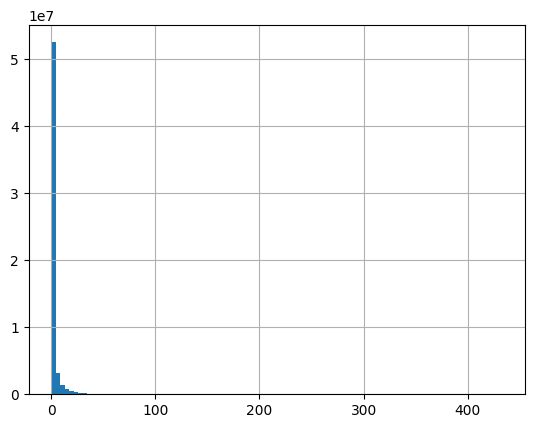

In [5]:
%%time
df = pd.read_csv("NSWrainfall/combined_data.csv")
print("Memory Usage", df.memory_usage().sum() / 1e6 , "MB")
print(df.describe())
df["rain (mm/day)"].hist(bins=100);

## 5.1 Changing dtype 

Memory Usage 2250.499196 MB
            lat_min       lat_max       lon_min       lon_max  rain (mm/day)
count  5.924854e+07  6.246784e+07  5.924854e+07  6.246784e+07   5.929456e+07
mean  -3.310491e+01 -3.197756e+01  1.469059e+02  1.482150e+02   1.901822e+00
std    1.963549e+00  1.992067e+00  3.793784e+00  3.809994e+00   5.588274e+00
min   -3.646739e+01 -3.600000e+01  1.406250e+02  1.412500e+02  -3.807373e-12
25%   -3.486911e+01 -3.366221e+01  1.434375e+02  1.450000e+02   3.876672e-06
50%   -3.300000e+01 -3.204189e+01  1.468750e+02  1.481250e+02   6.161705e-02
75%   -3.140170e+01 -3.015707e+01  1.501875e+02  1.513125e+02   1.021314e+00
max   -2.990000e+01 -2.790606e+01  1.537500e+02  1.556250e+02   4.329395e+02
CPU times: user 1min 3s, sys: 6.57 s, total: 1min 9s
Wall time: 1min 9s


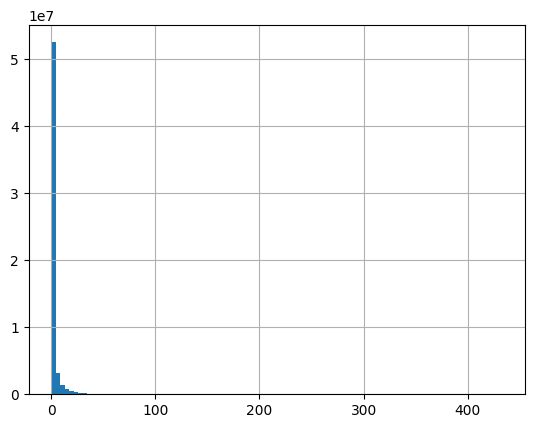

In [6]:
%%time
df_dtype = pd.read_csv("NSWrainfall/combined_data.csv",
                       dtype={'lat_min': np.float32,
                              'lat_max': np.float32,
                              'lon_min': np.float32,
                              'lon_max': np.float32,
                              'rain (mm/day)': np.float32,
                              'model': str})
print("Memory Usage", df_dtype.memory_usage().sum() / 1e6 , "MB")
print(df_dtype.describe())
df_dtype["rain (mm/day)"].hist(bins=100);

## 5.2 Load Only Columns Needed

Memory Usage 1500.33284 MB
            lat_min       lon_min  rain (mm/day)
count  5.924854e+07  5.924854e+07   5.929456e+07
mean  -3.310482e+01  1.469059e+02   1.901827e+00
std    1.963549e+00  3.793784e+00   5.588275e+00
min   -3.646739e+01  1.406250e+02  -3.807373e-12
25%   -3.486911e+01  1.434375e+02   3.876672e-06
50%   -3.300000e+01  1.468750e+02   6.161705e-02
75%   -3.140170e+01  1.501875e+02   1.021314e+00
max   -2.990000e+01  1.537500e+02   4.329395e+02
CPU times: user 40.4 s, sys: 6.23 s, total: 46.7 s
Wall time: 46.8 s


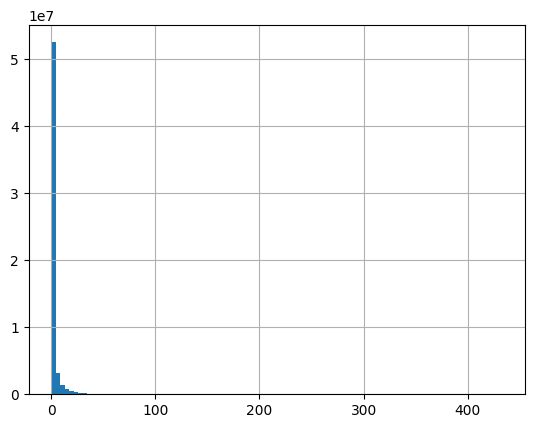

In [7]:
%%time
df_cols = pd.read_csv("NSWrainfall/combined_data.csv",
                      usecols=['lat_min', 'lon_min', "rain (mm/day)"])
print("Memory Usage", df_cols.memory_usage().sum() / 1e6 , "MB")
print(df_cols.describe())
df_cols["rain (mm/day)"].hist(bins=100);

### 6. Perform a simple EDA in R
rubric={correctness:15,reasoning:10}

1. Choose one of the methods listed below for transferring the dataframe (i.e., the entire dataset) from Python to R, and explain why you opted for this approach instead of the others.
    - [Parquet file](https://pages.github.ubc.ca/MDS-2022-23/DSCI_525_web-cloud-comp_students/lectures/lecture2.html#converting-csv-parquet)
    - [Pandas exchange](https://pages.github.ubc.ca/MDS-2022-23/DSCI_525_web-cloud-comp_students/lectures/lecture1.html#use-r-and-python-interchangeably)
    - [Arrow exchange](https://pages.github.ubc.ca/MDS-2022-23/DSCI_525_web-cloud-comp_students/lectures/lecture2.html#use-r-and-python-interchangeably-with-arrow)
2. Once you have the dataframe in R, perform a simple EDA.

First we opted for the simplest `pandas exchange` method but the cell took longer than 45 minutes to run because of the serialization and deserialization process (as we saw in Lecture 1). This process was aborted as `pandas exchange` is not suitable for transferring dataset of this size. Alternatively, we tried the `arrow exchange` method which is still easy to use and much more efficient. This method supports zero-copy data sharing between different programming languages and is integrated with essential R libraries such as `Dplyr` and `Lubridate`. Below, we can see it took just over one minute to transfer the data using Arrow and then just a few seconds for each cell of the EDA. Although `Parquet` is another option, we did not use it das we did not find it necessary to convert our CSV files to Parquet files for this milestone.

In [8]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
#Using brute force - pandas exchange method
%%R -i df
df_r <- as.data.frame(df)

In [4]:
%%R
head(df_r)

                 time   lat_min   lat_max lon_min lon_max rain (mm/day)
0 1889-01-01 12:00:00 -35.81152 -34.86911 140.625 141.875  5.134920e-01
1 1889-01-02 12:00:00 -35.81152 -34.86911 140.625 141.875  9.230450e-04
2 1889-01-03 12:00:00 -35.81152 -34.86911 140.625 141.875  9.390591e-06
3 1889-01-04 12:00:00 -35.81152 -34.86911 140.625 141.875  2.520761e-05
4 1889-01-05 12:00:00 -35.81152 -34.86911 140.625 141.875  1.330720e-05
5 1889-01-06 12:00:00 -35.81152 -34.86911 140.625 141.875  1.286928e-05
       model
0 NorESM2-MM
1 NorESM2-MM
2 NorESM2-MM
3 NorESM2-MM
4 NorESM2-MM
5 NorESM2-MM


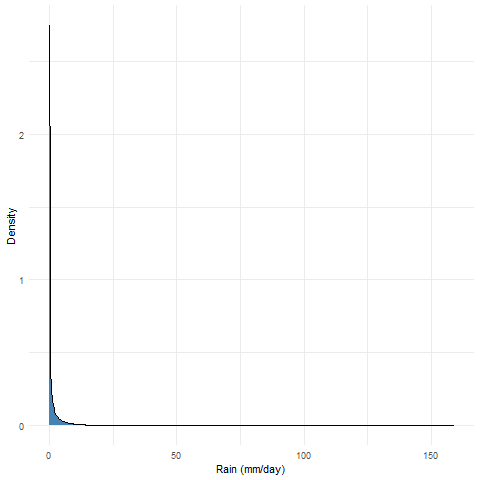

In [6]:
%%R
library(ggplot2)
df_r$rain <- as.numeric(df_r$`rain (mm/day)`)
df_r <- df_r[!is.na(df_r$rain),]

ggplot(df_r, aes(x = rain)) +
  geom_density(fill = "steelblue") +
  labs(x = "Rain (mm/day)", y = "Density") +
  theme_minimal()

In [4]:
## Using the arrow method

path = "/Users/rk/github/DSCI525_group16/notebooks/NSWRainfall/combined_data.csv"
# !pip install rpy2_arrow
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [6]:
%%time
csv_data = ds.dataset(path, format="csv")
# Converting the `pyarrow dataset` to a `pyarrowtable`
table = csv_data.to_table()
# Converting a `pyarrow table` to a `rarrow table`
r_table = pyra.converter.py2rpy(table)

CPU times: user 34.4 s, sys: 8.24 s, total: 42.6 s
Wall time: 1min 7s


In [9]:
%%time

%%R -i r_table
suppressMessages(library(dplyr))
output <- r_table %>% count(model) %>% collect()
print(output)

# A tibble: 28 × 2
   model                  n
   <chr>              <int>
 1 BCC-CSM2-MR      3035340
 2 GFDL-ESM4        3219300
 3 NorESM2-MM       3541230
 4 INM-CM4-8        1609650
 5 EC-Earth3-Veg-LR 3037320
 6 SAM0-UNICON      3541153
 7 ACCESS-CM2       1932840
 8 FGOALS-g3        1287720
 9 CanESM5           551880
10 CMCC-CM2-HR4     3541230
# ℹ 18 more rows
# ℹ Use `print(n = ...)` to see more rows
CPU times: user 4.96 s, sys: 4.65 s, total: 9.61 s
Wall time: 7.38 s


In [10]:
%%time

%%R -i r_table
glimpse(r_table)

Table
62,513,863 rows x 7 columns
$ time      <timestamp[s]> 1889-01-01 04:00:00, 1889-01-02 04:00:00, 1889-01-03 …
$ lat_min         <double> -35.88765, -35.88765, -35.88765, -35.88765, -35.88765…
$ lat_max         <double> -34.76616, -34.76616, -34.76616, -34.76616, -34.76616…
$ lon_min         <double> 141.1875, 141.1875, 141.1875, 141.1875, 141.1875, 141…
$ lon_max         <double> 142.3125, 142.3125, 142.3125, 142.3125, 142.3125, 142…
$ `rain (mm/day)` <double> 4.265520e-17, 2.728501e-20, 5.221255e-24, 2.869350e-1…
$ model           <string> "BCC-CSM2-MR", "BCC-CSM2-MR", "BCC-CSM2-MR", "BCC-CSM…
CPU times: user 51.5 ms, sys: 11.2 ms, total: 62.7 ms
Wall time: 101 ms
